# Chapter 7 
 Modern Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (September 15, 2022) <br>
ISBN-13: 978-3031075650

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored. 
"Errors" will stop execution and need to be fixed in order to get results. 

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Check the errata at (https://gedeck.github.io/mistat-code-solutions/ModernStatistics/) and the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues to see if the issue is known and a solution available.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [1]:
import warnings
import os
os.environ['OUTDATED_IGNORE'] = '1'
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

# Modern analytic methods: Part I

In [2]:
import warnings
import random
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.formula.api as smf

from scipy import stats
import matplotlib.pyplot as plt
import mistat

## Decision Trees

Load the breast cancer data provided with scikit-learn (reference https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

In [3]:
from sklearn.datasets import load_breast_cancer
cancer_df = load_breast_cancer(as_frame=True)['frame']
predictors = [c for c in cancer_df.columns if c != 'target']
outcome = 'target'
X = cancer_df[predictors]
y = cancer_df[outcome]

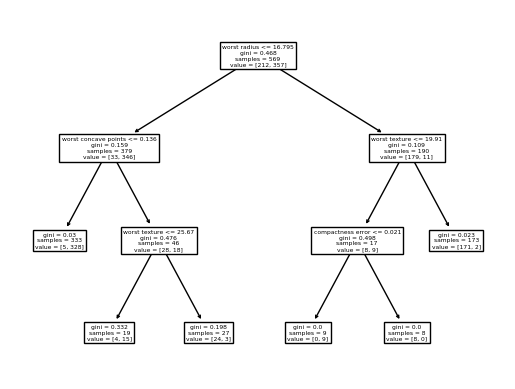

In [4]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Train the model
clf = DecisionTreeClassifier(ccp_alpha=0.012, random_state=0)
clf.fit(X, y)

# Visualization of tree
plot_tree(clf, feature_names=list(X.columns))
plt.show()

In [5]:
# Text representation of tree
print(export_text(clf, feature_names=list(X.columns)))

|--- worst radius <= 16.80
|   |--- worst concave points <= 0.14
|   |   |--- class: 1
|   |--- worst concave points >  0.14
|   |   |--- worst texture <= 25.67
|   |   |   |--- class: 1
|   |   |--- worst texture >  25.67
|   |   |   |--- class: 0
|--- worst radius >  16.80
|   |--- worst texture <= 19.91
|   |   |--- compactness error <= 0.02
|   |   |   |--- class: 1
|   |   |--- compactness error >  0.02
|   |   |   |--- class: 0
|   |--- worst texture >  19.91
|   |   |--- class: 0



In [6]:
import dtreeviz

# the dtreeviz methods requires the classifier to be trained with a numerical
# representation of the classes
X = cancer_df[predictors]
y = cancer_df[outcome]

# Train the model
clf = DecisionTreeClassifier(ccp_alpha=0.012, random_state=0)
clf.fit(X.values, y)

warnings.simplefilter('ignore', category=UserWarning)
viz_model = dtreeviz.model(clf, X, y,
               target_name=outcome,
               feature_names=X.columns,
               class_names=['Pass', 'Flag'])
warnings.simplefilter('default', category=UserWarning)

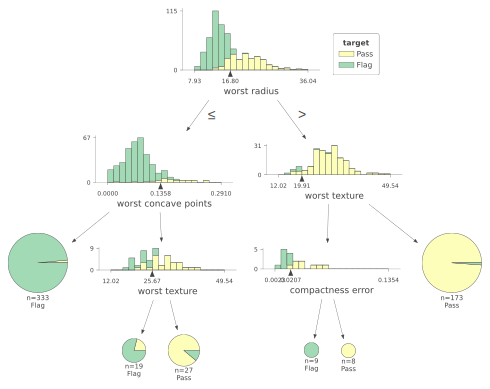

In [7]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True  # suppress missing font warnings
viz_model.view()

Probabilities of missclassified data points
[[0.21052632 0.78947368]
 [0.01501502 0.98498498]
 [0.01501502 0.98498498]
 [0.21052632 0.78947368]
 [0.01501502 0.98498498]
 [0.21052632 0.78947368]
 [0.01501502 0.98498498]
 [0.98843931 0.01156069]
 [0.21052632 0.78947368]
 [0.88888889 0.11111111]
 [0.01501502 0.98498498]
 [0.98843931 0.01156069]
 [0.88888889 0.11111111]
 [0.88888889 0.11111111]]
Confusion matrix
[[203   9]
 [  5 352]]


/usr/local/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
/usr/local/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
/usr/local/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names


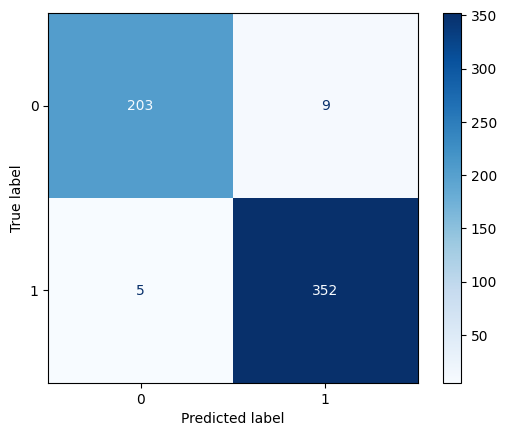

In [8]:
# missclassification probabilities
print('Probabilities of missclassified data points')
print(clf.predict_proba(X.loc[clf.predict(X) != y,:]))

# actual in rows / predicted in columns
print('Confusion matrix')
cm = confusion_matrix(y, clf.predict(X))
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

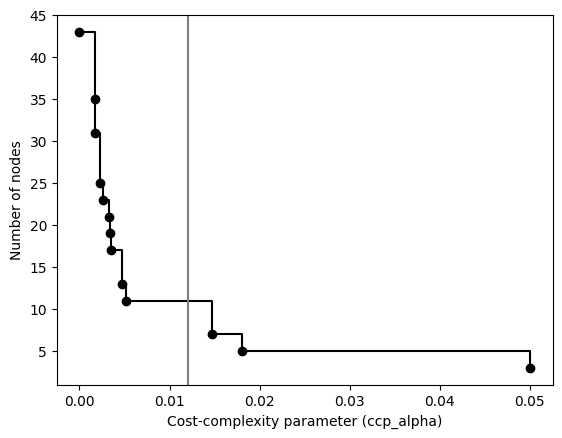

In [9]:
# Code to analyze tree depth vs alpha
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
fig, ax = plt.subplots()
ax.plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post",
        color='black')
ax.set_xlabel("Cost-complexity parameter (ccp_alpha)")
ax.set_ylabel("Number of nodes")
ax.axvline(0.012, color='grey')
plt.show()

## Ensemble Models

In [10]:
X = cancer_df[predictors]
y = cancer_df[outcome]

# Train the model
clf = RandomForestClassifier(ccp_alpha=0.012, random_state=0)
clf.fit(X, y)

# actual in rows / predicted in columns
print('Confusion matrix')
print(confusion_matrix(y, clf.predict(X)))

Confusion matrix
[[202  10]
 [  6 351]]


In [11]:
# On some versions of MACOS, running xgboost can fail. Uncomment the following
# lines to avoid this.
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [12]:
from xgboost import XGBClassifier

# Train the model
xgb = XGBClassifier(objective='binary:logistic', subsample=.63,
                    eval_metric='logloss')
xgb.fit(X, y)

# actual in rows / predicted in columns
print('Confusion matrix')
print(confusion_matrix(y, xgb.predict(X)))

Confusion matrix
[[212   0]
 [  0 357]]


## Na\"ive Bayes Classifier

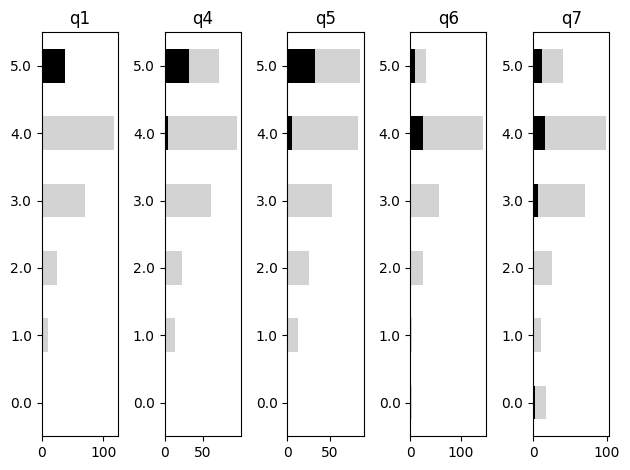

In [13]:
abc = mistat.load_data('ABC.csv')
all_questions = [c for c in abc.columns if c.startswith('q')]
abc[all_questions] = abc[all_questions].astype('category')

questions = ['q1', 'q4', 'q5', 'q6', 'q7']
q1_5 = (abc['q1'] == 5)

fig, axes = plt.subplots(ncols=len(questions))
for ax, question in zip(axes, questions):
  response = abc[question]
  df = pd.DataFrame([
    {satisfaction: counts for satisfaction, counts
      in response.value_counts().items()},
    {satisfaction: counts for satisfaction, counts
      in response[q1_5].value_counts().items()},
  ])
  df = df.transpose()  # flip columns and rows
  # add rows of 0 for missing satisfaction
  for s in range(6):
    if s not in df.index:
      df.loc[s] = [0, 0]
  df = df.fillna(0)  # change missing values to 0
  df = df.sort_index()  # the index contains the satisfaction
  df.columns = ['counts', 'counts_q1_5']  # rename the columns
  df['counts'].plot.barh(y='index', ax=ax, color='lightgrey')
  df['counts_q1_5'].plot.barh(y='index', ax=ax, color='black')
  ax.set_ylim(-0.5, 5.5)
  ax.set_title(question)
plt.tight_layout()
plt.show()

In [14]:
predictors = list(all_questions)
predictors.remove('q1')
target = 'q1'
# q1 has missing values - remove rows from dataset
q1_missing = abc[target].isna()
X = abc.loc[~q1_missing, predictors]
y = abc.loc[~q1_missing, target]

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X = imp.fit_transform(X)

In [15]:
nb_model = MultinomialNB()
nb_model.fit(X, y)
print(confusion_matrix(y, nb_model.predict(X)))
print(accuracy_score(y, nb_model.predict(X)))

[[ 7  2  2  0  0]
 [ 3 14  4  4  0]
 [ 8  6 35 16  5]
 [ 9  1 12 66 30]
 [ 3  0  2 12 21]]
0.5458015267175572


In [16]:
dt_model = DecisionTreeClassifier(ccp_alpha=0.014, random_state=0)
_ = dt_model.fit(X, y)

In [17]:
print(confusion_matrix(y, dt_model.predict(X)))
print(accuracy_score(y, dt_model.predict(X)))

[[  8   3   0   0   0]
 [  1  19   4   1   0]
 [  2   4  51  13   0]
 [  1   2  13 102   0]
 [  0   0   0  19  19]]
0.7595419847328244


In [18]:
rf_model = RandomForestClassifier(ccp_alpha=0.014, random_state=0)
_ = rf_model.fit(X, y)

In [19]:
print(confusion_matrix(y, rf_model.predict(X)))
print(accuracy_score(y, rf_model.predict(X)))

[[  4   2   4   1   0]
 [  0  14   8   3   0]
 [  0   0  64   6   0]
 [  0   0   1 116   1]
 [  0   0   0  14  24]]
0.8473282442748091


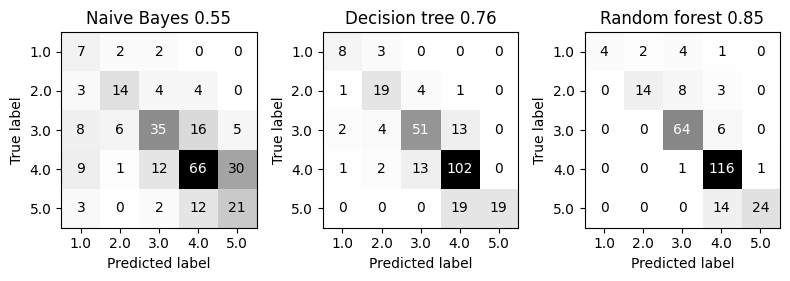

In [20]:
fig, axes = plt.subplots(ncols=3, figsize=(8, 3))
axes[0].set_title(f'Naive Bayes {accuracy_score(y, nb_model.predict(X)):.2f}')
ConfusionMatrixDisplay.from_estimator(nb_model, X, y, ax=axes[0],
  cmap=plt.cm.Greys, colorbar=False)
axes[1].set_title(f'Decision tree {accuracy_score(y, dt_model.predict(X)):.2f}')
ConfusionMatrixDisplay.from_estimator(dt_model, X, y, ax=axes[1],
  cmap=plt.cm.Greys, colorbar=False)
axes[2].set_title(f'Random forest {accuracy_score(y, rf_model.predict(X)):.2f}')
ConfusionMatrixDisplay.from_estimator(rf_model, X, y, ax=axes[2],
  cmap=plt.cm.Greys, colorbar=False)
plt.tight_layout()
plt.show()

## Neural Networks

In [21]:
from sklearn.datasets import load_breast_cancer
cancer_df = load_breast_cancer(as_frame=True)['frame']
predictors = [c for c in cancer_df.columns if c != 'target']
outcome = 'target'
X = cancer_df[predictors]
y = cancer_df[outcome]

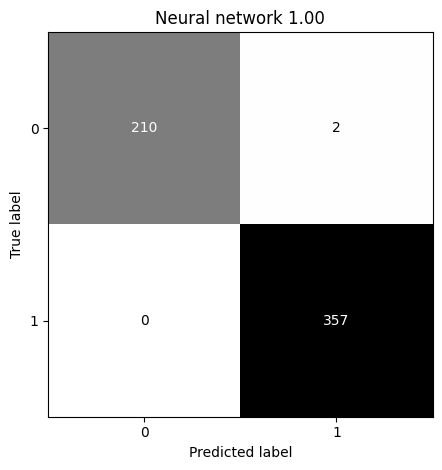

In [22]:
# scale predictor variables to interval (0, 1)
X = MinMaxScaler().fit_transform(X)

clf = MLPClassifier(hidden_layer_sizes=(3, ), activation='logistic',
                    solver='lbfgs', max_iter=1000,
                    random_state=1)
clf.fit(X, y)
# clf.predict(X)
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(clf, X, y, ax=ax,
  cmap=plt.cm.Greys, colorbar=False)

ax.set_title(f'Neural network {accuracy_score(y, clf.predict(X)):.2f}')
plt.tight_layout()

## Clustering Methods

### Hierarchical Clustering

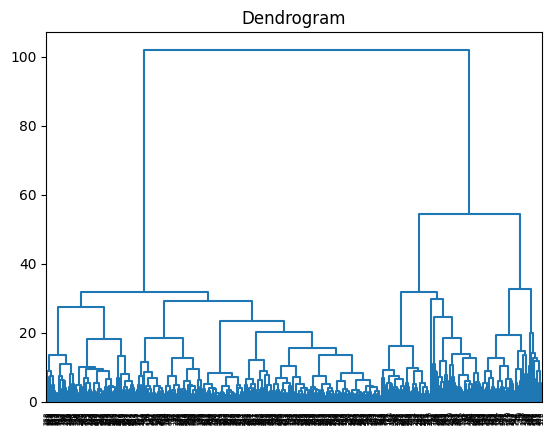

In [23]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from mistat import plot_dendrogram

scaler = StandardScaler()
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(scaler.fit_transform(X))

fig, ax = plt.subplots()
plot_dendrogram(model, ax=ax)
ax.set_title('Dendrogram')
plt.show()

### $K$-means Clustering

In [24]:
from sklearn.cluster import KMeans


scaler = StandardScaler()
model = KMeans(n_clusters=5, random_state=1).fit(scaler.fit_transform(X))
print('Cluster membership (first two data points)')
print(model.predict(X)[:2])
print()
print('Distance to cluster center (first two data points)')
model.transform(X)[:2,:]

Cluster membership (first two data points)
[2 2]

Distance to cluster center (first two data points)


array([[5.6933219 , 3.48310224, 2.62218775, 4.47119004, 6.41237672],
       [4.56347115, 4.45757783, 2.2490394 , 3.8378753 , 7.20323171]])

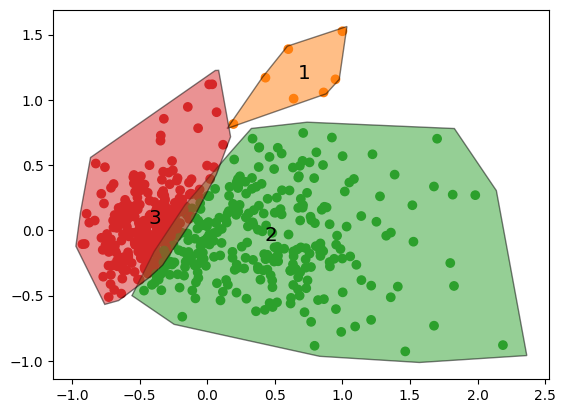

In [25]:
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

def visualizeClusters(X, model):
    # use PCA to map the dataset into a 2D space
    pca = PCA(n_components=2).fit(X)
    coord = pca.transform(X)
    
    fig, ax = plt.subplots()
    df = pd.DataFrame({'x': coord[:,0], 'y': coord[:,1],
                       'cluster': model.predict(X)})
    colors = [f'C{i}' for i in model.predict(X)]
    ax.scatter(df.x, df.y, color=[f'C{cl}' for cl in df.cluster])
    
    from matplotlib.patches import Polygon
    for cl, x in df.groupby('cluster'):
      x = x.values[:, :2]
      cent = np.mean(x, axis=0)
      if len(x) == 1:
        pass
      elif len(x) == 2:
        ax.plot(x[:,0], x[:,1], color='black', alpha=0.5)
      else:
        hull = ConvexHull(x)
        pts = []
        for pt in x[hull.simplices]:
            pts.append(pt[0].tolist())
            pts.append(pt[1].tolist())
    
        pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                        p[0] - cent[0]))
        pts = pts[0::2]  # Deleting duplicates
        pts.insert(len(pts), pts[0])
        k = 1.1
        color = 'green'
        poly = Polygon(k*(np.array(pts)- cent) + cent, edgecolor='black',
                       facecolor=f'C{cl}', alpha=0.5)
        poly.set_capstyle('round')
        ax.add_patch(poly)
      ax.text(*cent, f'{cl}', fontsize='x-large')
    plt.show()
visualizeClusters(X, model)

### Cluster Number Selection

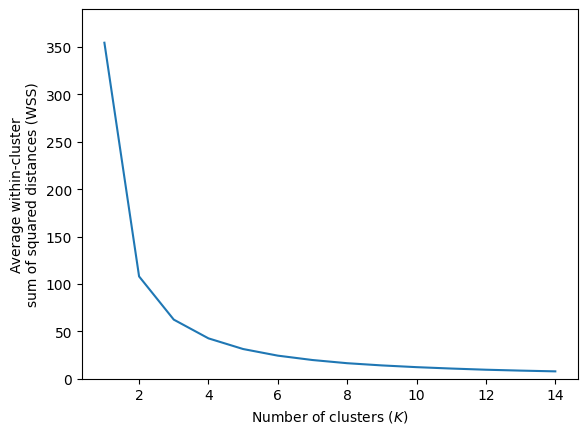

In [26]:
inertia = []

for n_clusters in range(1, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 15), 'inertia': inertia})

ax = inertias.plot(x='n_clusters', y='inertia')
ax.set_xlabel(r'Number of clusters ($K$)')
ax.set_ylabel('Average within-cluster\nsum of squared distances (WSS)')
ax.set_ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

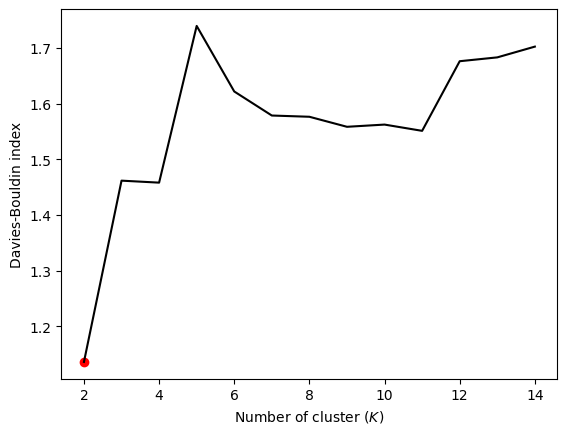

In [27]:
from sklearn import metrics

ss = []
range_n_clusters = list(range(2, 15))
for n_clusters in range_n_clusters:
   clusterer = KMeans(n_clusters = n_clusters, random_state=1)
   cluster_labels = clusterer.fit_predict(X)

   score = metrics.davies_bouldin_score(X, cluster_labels)
   ss.append(score)
opt_index = np.argmin(ss)

fig, ax = plt.subplots()
ax.plot(range_n_clusters, ss,'-', color='black')
ax.scatter(range_n_clusters[opt_index], ss[opt_index], color='red')
ax.set_xlabel(r'Number of cluster ($K$)')
ax.set_ylabel('Davies-Bouldin index')
plt.show()

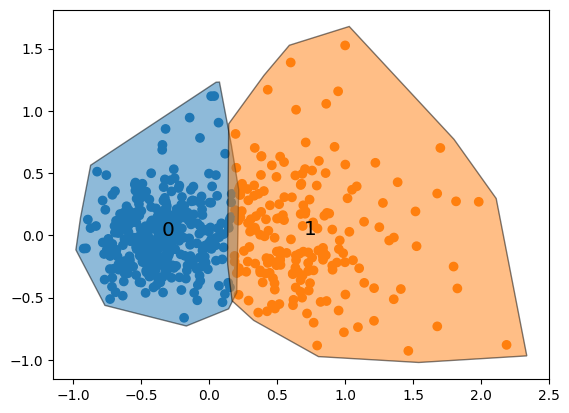

In [28]:
model = KMeans(n_clusters=2, random_state=1)
model.fit(X)
visualizeClusters(X, model)